# BIRDS

This is a small project utilizing the differenet GenAI architectures to generate new bird common names.

In [ ]:
import csv
from matplotlib import pyplot as plt

with open('../data/birds.csv', newline='') as f:
    reader = csv.reader(f)
    data = [n for _,n in list(reader)[1:]]

data_lower = list(map(str.lower, data))

chars = set()
for s in data_lower:
    chars = chars.union(s)
chars = sorted(list(chars))
chars_to_drop = set(list(chars[30:]) + ['.'])
data = list(filter(lambda n: not chars_to_drop.intersection(n), data_lower))

chars = ['#'] + list(sorted(set(chars).difference(chars_to_drop)))
vocab_size = len(chars)

ch2i = { ch:i for i,ch in enumerate(chars)}
i2ch = { i:ch for i,ch in enumerate(chars)}

print(f'{len(data)=}, {vocab_size=}')

len(data)=10817, vocab_size=30


In [2]:
import torch
from torch import nn
import torch.nn.functional as F

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


# GRU/LRU

In [3]:
block_size = 8
emd_dim = 4
hidden_dim = 200
n_hidden_layers = 2

In [4]:
def build_dataset(data):
    xs, ys = [], []

    for name in data:
        chrs = ['#']*block_size + list(name) + ['#']
        for ix in range(len(chrs)-block_size):
            xs.append([ch2i[ch] for ch in chrs[ix:ix+block_size]])
            ys.append(ch2i[chrs[ix+block_size]])

    X = torch.tensor(xs)
    Y = torch.tensor(ys)

    return X, Y

In [5]:
import random
random.seed(0)
random.shuffle(data)

n1 = int(len(data)*0.9)
n2 = int(len(data)*0.95)

X_train, Y_train = build_dataset(data[:n1])
X_valid, Y_valid = build_dataset(data[n1:n2])
X_test, Y_test = build_dataset(data[n2:])

X_total = torch.cat([X_train, X_valid, X_test])
Y_total = torch.cat([Y_train, Y_valid, Y_test])

In [6]:
n1, n2, len(data), len(X_train), len(X_valid), len(X_test)

(9735, 10276, 10817, 191515, 10650, 10624)

# Classes

In [7]:
g = torch.Generator().manual_seed(42)

In [8]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.fan_in = fan_in
        self.fan_out = fan_out
        self.bias = bias
        self.W = torch.randn((fan_in, fan_out), generator=g) / (fan_in**0.5)
        self.b = torch.zeros(fan_out) if bias else None

    #     self.W = torch.empty(fan_in, fan_out)
    #     self.b = torch.empty(fan_out) if bias else None
    #     self.reset_parameters()

    # def reset_parameters(self):
    #     nn.init.kaiming_uniform_(self.W, a=self.fan_in**0.5, mode='fan_in', nonlinearity='tanh', generator=g)
    #     if self.bias:
    #         bound = 1 / self.fan_in**0.5
    #         nn.init.uniform_(self.b, -bound, bound, generator=g)
    
    def __call__(self, x):
        self.out = x @ self.W + self.b if self.bias else x @ self.W
        return self.out
    
    def parameters(self):
        return [self.W] + ([self.b] if self.bias else [])
    
    
class BatchNorm1d:

    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        # buffers
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)
    
    def __call__(self, x):
        if self.training:
            mean = x.mean(0, keepdim=True)
            var = x.var(0, keepdim=True, unbiased=False)
        else:
            mean = self.running_mean
            var = self.running_var
        x = (x - mean) / (var + self.eps).sqrt()
        self.out = self.gamma * x + self.beta
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [9]:
class Model:

    def __init__(self, vocab_size, emd_dim, hidden_dim, n_hidden_layers):
        self.C = torch.randn(vocab_size, emd_dim)
        self.layers = [
            Linear(emd_dim*block_size, hidden_dim), BatchNorm1d(hidden_dim), Tanh(),
        ]
        for _ in range(n_hidden_layers):
            self.layers += [
                Linear(hidden_dim, hidden_dim), BatchNorm1d(hidden_dim), Tanh(),
            ]
        self.layers += [
            Linear(hidden_dim, vocab_size), BatchNorm1d(vocab_size),
        ]
        with torch.no_grad():
            # self.layers[-1].W *= .1
            self.layers[-1].gamma *= .1
        #     for layer in self.layers[:-1:3]:
        #         layer.W *= 5/3
        for p in self.parameters():
            p.requires_grad = True

    def parameters(self):
        return [self.C] + [p for layer in self.layers for p in layer.parameters()]
    
    def predict(self, x):
        x = self.C[x].view(-1, emd_dim*block_size)
        for layer in self.layers:
            x = layer(x)
        return x
    
    def train(self, x, y, lr):
        out = self.predict(x)
        loss = F.cross_entropy(out, y)
        for p in self.parameters():
            p.grad = None
        loss.backward()
        with torch.no_grad():
            for p in self.parameters():
                p -= p.grad * lr
        return loss

In [10]:
MLP = Model(vocab_size, emd_dim, hidden_dim, n_hidden_layers)
parameters = MLP.parameters()

print(f'Number of parameters: {sum(p.numel() for p in parameters)}')

Number of parameters: 94410


In [11]:
steps = 100000
lr = .1
batch_size = 64
print(f'Expected loss at initialization: {-torch.tensor(1/vocab_size).log().item():.4f}')

Expected loss at initialization: 3.4012


In [12]:
lossi = []
lossi_valid = []
loglossi = []
ud = []

for i in range(steps):

    if (i%(steps//2)) == 0 and i > 0:
        lr /= 10

    ixs = torch.randint(0, X_train.size()[0], (batch_size,))
    loss = MLP.train(X_train[ixs], Y_train[ixs], lr)
    lossi.append(loss.item())
    loglossi.append(loss.log10().item())
    if i % (steps//500) == 0:
        for layer in MLP.layers:
            if isinstance(layer, BatchNorm1d):
                layer.training = False
        with torch.no_grad():
            lossi_valid.append(F.cross_entropy(MLP.predict(X_valid), Y_valid).item())
        for layer in MLP.layers:
            if isinstance(layer, BatchNorm1d):
                layer.training = True
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in MLP.parameters()])

    if i % (steps//10) == 0:
        print(f'{i=}, {lossi[i]=}')

i=0, lossi[i]=3.3996965885162354
i=10000, lossi[i]=1.2461090087890625
i=20000, lossi[i]=1.2380002737045288
i=30000, lossi[i]=1.0233463048934937
i=40000, lossi[i]=0.9741746187210083
i=50000, lossi[i]=1.1709614992141724
i=60000, lossi[i]=0.8675900101661682
i=70000, lossi[i]=0.6337225437164307
i=80000, lossi[i]=0.6313490867614746
i=90000, lossi[i]=0.8872919678688049


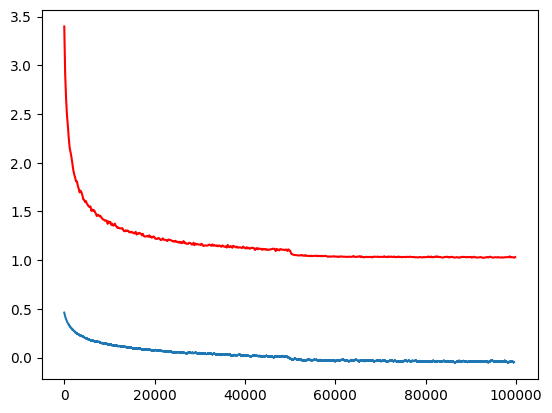

In [13]:
roll = 500
rolling_loss = [sum(loglossi[i:i+roll])/roll for i in range(len(lossi)-roll)]

fig = plt.figure()
plt.plot(rolling_loss)
plt.plot(range(0,len(rolling_loss)+2*steps//500, steps//500), lossi_valid, 'r')

layer i=1 (BatchNorm1d), t.mean()=-0.01, t.std()=1.72, % saturated: 54.40
layer i=4 (BatchNorm1d), t.mean()=-0.00, t.std()=1.94, % saturated: 62.29
layer i=7 (BatchNorm1d), t.mean()= 0.02, t.std()=2.01, % saturated: 66.97
layer i=10 (BatchNorm1d), t.mean()= 0.00, t.std()=3.86, % saturated: 78.33


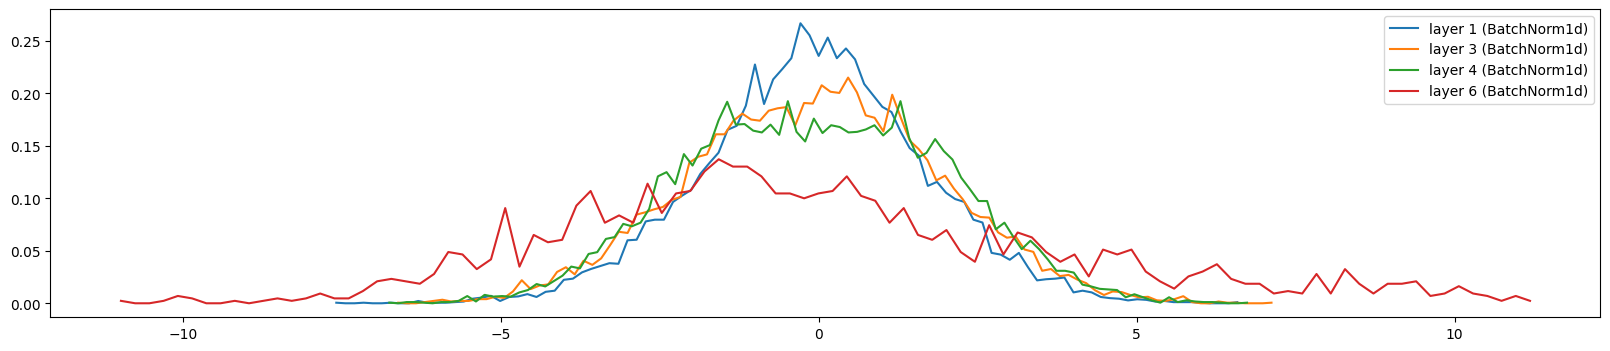

In [14]:
plt.figure(figsize=(20,4))
lengeds = []
for i,layer in enumerate(MLP.layers):
    if i%3 == 1:
        t = layer.out
        print(f'layer {i=} ({layer.__class__.__name__}), {t.mean()=: 2.2f}, {t.std()=:.2f}, % saturated: {((t.abs()>.99).sum().float()/t.numel()*100).item():.2f}')
        hy, hx = torch.histogram(t, density=True, bins=100)
        plt.plot(hx[:-1].detach().numpy(), hy.detach().numpy())
        lengeds.append(f'layer {i//2+1} ({layer.__class__.__name__})')
plt.legend(lengeds)

(torch.Size([30, 4])   ), mean=+6.8297e-10, std=2.6453e-02, grad/data=2.0847e-02
(torch.Size([32, 200]) ), mean=-7.2512e-05, std=1.1333e-02, grad/data=3.9557e-02
(torch.Size([200, 200])), mean=-3.4431e-05, std=6.1999e-03, grad/data=3.8882e-02
(torch.Size([200, 200])), mean=+3.0270e-05, std=6.3576e-03, grad/data=3.8098e-02
(torch.Size([200, 30]) ), mean=+4.6188e-05, std=1.1409e-02, grad/data=3.5014e-02


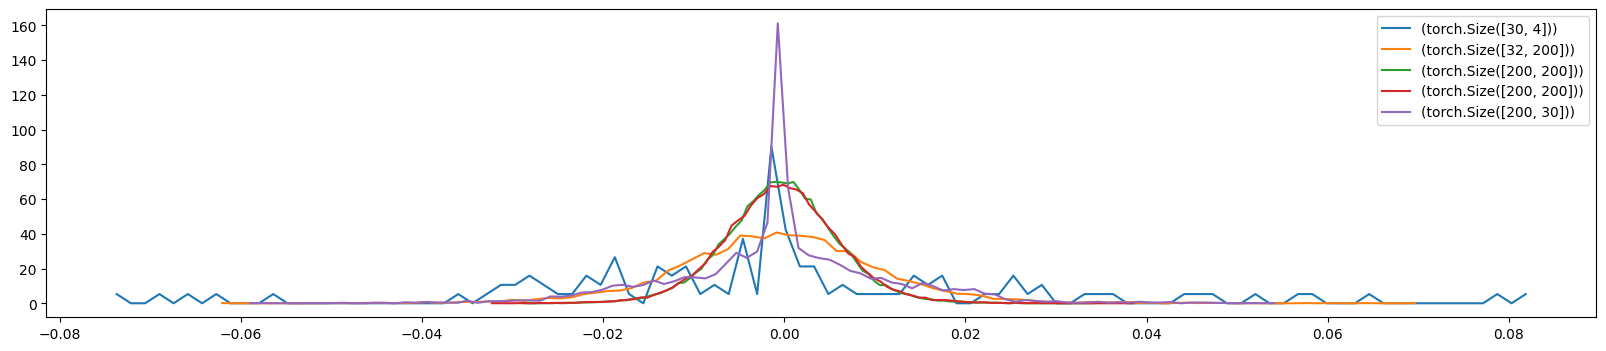

In [15]:
plt.figure(figsize=(20,4))
lengeds = []
for i,p in enumerate(MLP.parameters()):
    if p.ndim == 2:
        t = p.grad
        print(f'({str(p.shape):22s}), mean={t.mean():+.4e}, std={t.std():.4e}, grad/data={t.abs().mean()/p.abs().mean():.4e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach().numpy(), hy.detach().numpy())
        lengeds.append(f'({p.shape})')
plt.legend(lengeds)

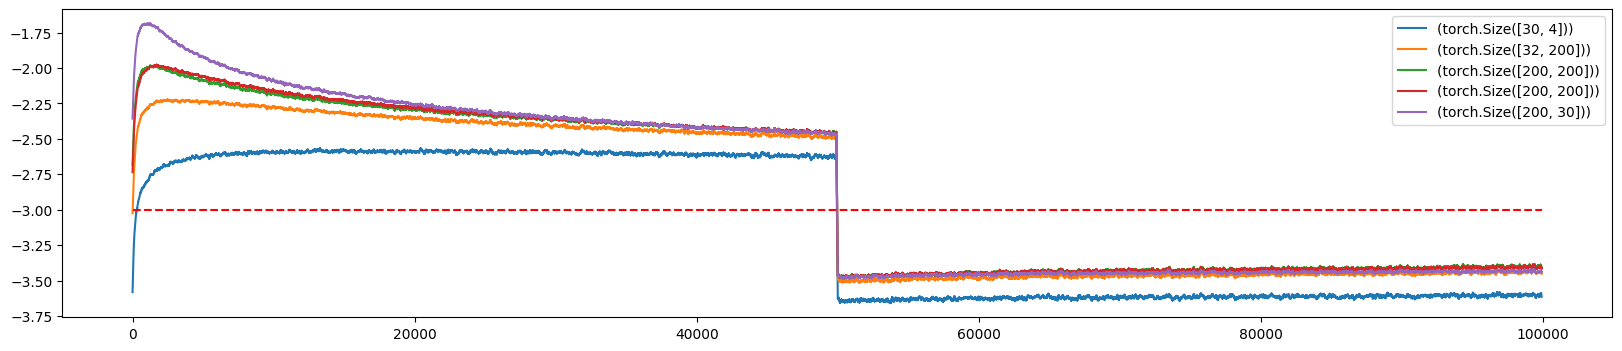

In [16]:
roll = 100
plt.figure(figsize=(20,4))
lengeds = []
for l,p in enumerate(MLP.parameters()):
    if p.ndim == 2:
        plt.plot([sum([ud[k][l] for k in range(i,i+roll)])/roll for i in range(len(ud)-roll)])
        lengeds.append(f'({p.shape})')
plt.plot([0, len(ud)-roll], [-3,-3], 'r--')
plt.legend(lengeds)

In [17]:
for layer in MLP.layers:
    if isinstance(layer, BatchNorm1d):
        layer.training = False

def compute_loss(X, Y):
    for layer in MLP.layers:
        if isinstance(layer, BatchNorm1d):
            layer.training = False
    Y_pred = MLP.predict(X)
    loss = F.cross_entropy(Y_pred, Y)
    print(f'{loss.item()=}')

compute_loss(X_train, Y_train)
compute_loss(torch.concat((X_valid, X_test)), torch.concat((Y_valid, Y_test)))

loss.item()=0.8317995667457581
loss.item()=1.0187804698944092


with block=20, emd_dim=4, hidden_dim=100, n_hidden_layers=4:
loss.item()=0.9029964208602905
loss.item()=1.0322859287261963

with block=8, emd_dim=4, hidden_dim=100, n_hidden_layers=4:
loss.item()=0.9119027853012085
loss.item()=1.0441724061965942

block_size = 8, emd_dim = 4, hidden_dim = 30, n_hidden_layers = 8
loss.item()=1.3387105464935303
loss.item()=1.3823189735412598

block_size = 8, emd_dim = 4, hidden_dim = 200, n_hidden_layers = 2
loss.item()=0.8265788555145264
loss.item()=1.014521598815918

In [18]:
temperature = 1.

# g = torch.Generator().manual_seed(0)
for _ in range(20):
    context = [ch2i['#']] * block_size
    while True:
        # forward pass
        Xc = torch.tensor(context).unsqueeze(0)
        logits = MLP.predict(Xc)
        logits = logits / temperature
        probs = F.softmax(logits, dim=1)

        next_ch = torch.multinomial(probs, 1, generator=g).item()
        context = context[1:] + [next_ch]
        if next_ch == ch2i['#']:
            print()
            break
        print(i2ch[next_ch], end='')

new caledonian roby
gernand eagle
blue-headed ground esteco
spot-breasted oriole
rusty-browed bulbul
little owl
japanese antpitta
hair-choosh
indigolian storm petrel
red-winged sandpiper
yellow-browed shelduck
white-headed bulbul
grey-capped storm petrel
lapaan flycatcher
carbling ipalis
palamupper
ungas lark
heary-crested-throated shelduck
dusky ttrea
black-faced cotinga
